# Cancer Diagnostics

Coded by Emile Badran in May/2018

This notebook aims to create a model to predict breast cancer and identify which traits are most indicative of whether or not an individual will be diagnosed.

**Acknowledgments**

The creator of the data set is Dr. WIlliam H. Wolberg (physician) from the University of Wisconsin Hospitals in Madison, Wisconsin, USA.

O. L. Mangasarian and W. H. Wolberg: "Cancer diagnosis via linear programming", SIAM News, Volume 23, Number 5, September 1990, pp 1 & 18.

Link to the data set:
https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

import time
import numpy as np
import pandas as pd
pd.options.display.max_columns = 100

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

import multiprocessing
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV

from IPython.display import Image
import pydotplus
import graphviz
from sklearn import tree

from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn import ensemble

%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


### Importing and inspecting the data set

In [2]:
# Load the raw data from an URL
url="http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"

# Read the URL into a data frame
raw_data = pd.read_csv(url, names=('sample_code', 'clump_thickness', 'cell_size', 'cell_shape',
                                   'marginal_adhesion', 'epithelial', 'nuclei', 'chromatin',
                                   'nucleoli', 'mitoses', 'malignant'))

In [3]:
# Convert target column to binary
raw_data.malignant = raw_data.malignant.apply(lambda x: 0 if x==2 else 1)

# Convert nuclei column to integer, drop null values, and reset index
raw_data.nuclei = pd.to_numeric(raw_data.nuclei, errors='coerce')
raw_data = raw_data.dropna()
raw_data.nuclei = raw_data.nuclei.astype('int64')
raw_data.reset_index(drop=True, inplace=True)

#### Attribute Information:

- Sample code number: id number 
- Clump Thickness: 1 - 10 
- Uniformity of Cell Size: 1 - 10 
- Uniformity of Cell Shape: 1 - 10 
- Marginal Adhesion: 1 - 10 
- Single Epithelial Cell Size: 1 - 10 
- Bare Nuclei: 1 - 10 
- Bland Chromatin: 1 - 10 
- Normal Nucleoli: 1 - 10 
- Mitoses: 1 - 10 
- Malignant: (0 for benign, 1 for malignant)

#### Inspecting variable correlation
A correlation heatmap below shows that variables are positively correlated - the higher the values, the greater the chances of cells being malignant.

In [4]:
# Generate the correlation matrix
corr_matrix = raw_data.iloc[:,1:].corr()

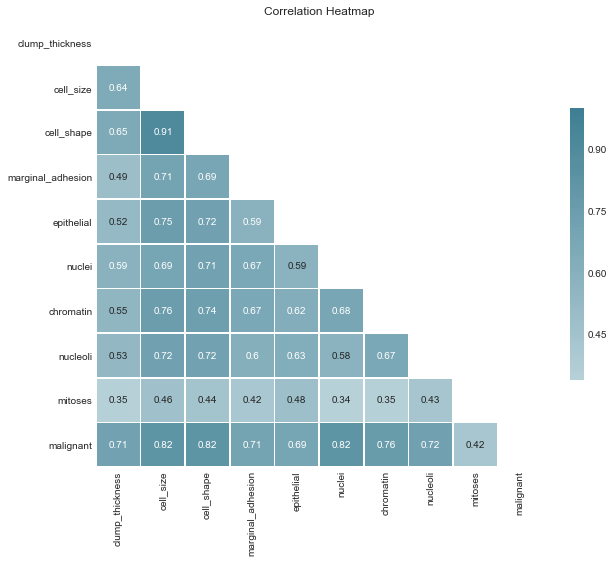

In [5]:
# Create a correlation heatmap
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix,
            mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
plt.title('Correlation Heatmap')
plt.show()

### Standardizing data

Some models, such as Logistic Regression and Support Vector Machines perform better when all variables have the same scale.

In [6]:
# Standardize all variables except 'sample_code' and 'malignant'
scaled_data = pd.DataFrame(data=preprocessing.scale(raw_data.iloc[:,1:-1]), columns=raw_data.columns[1:-1])
scaled_data['malignant'] = raw_data.malignant.values
scaled_data.head(2)

,clump_thickness,cell_size,cell_shape,marginal_adhesion,epithelial,nuclei,chromatin,nucleoli,mitoses,malignant
0,0.197905,-0.702212,-0.741774,-0.639366,-0.555608,-0.698853,-0.181827,-0.612927,-0.3484,0
1,0.197905,0.277252,0.262783,0.758032,1.695166,1.772867,-0.181827,-0.285105,-0.3484,0


#### Inspecting variance and outliers
The boxplot below shows that some of the variables (most notably 'mitoses') have outliers.

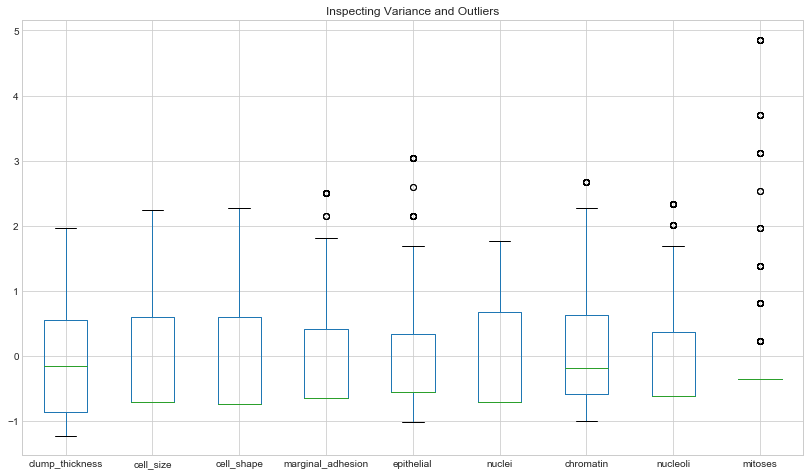

In [7]:
# Plot a boxplot to inspect variance
scaled_data.iloc[:,:-1].boxplot(figsize=(14,8), grid=True)
plt.title('Inspecting Variance and Outliers')
plt.show()

### Principal Component Analysis
Principal Component Analyisis (PCA) is a statistical procedure that reduces the set of variables (or dimensions) to a smaller set of components that represent most of the information in the original data set.

In [8]:
# Call the PCA function with the desired number of components
pca = PCA(n_components=3)

# Fit the PCA function and store components in variable
components = pca.fit_transform(scaled_data.iloc[:,:-1])

# Inspect components' variance ratios
print('PCA components:\n', pca.explained_variance_ratio_)
print('\nThe percentage of total variance in the dataset explained by components:\n',
      sum(pca.explained_variance_ratio_))

# Store components and target variable on DataFrame
pca_data = pd.DataFrame(data=components, columns=['c1','c2','c3'])
pca_data['malignant'] = raw_data.malignant

pca_data.head(2)

PCA components:
 [0.65549993 0.08621632 0.05991692]

The percentage of total variance in the dataset explained by components:
 0.8016331637984968


,c1,c2,c3,malignant
0,-1.470171,-0.104273,-0.565685,0
1,1.442046,-0.570141,0.236601,0


### Resampling the data set to compensate class imbalance
The data set is slightly imbalanced and will need to be resampled: 35% of the observations are malign and 65% are benign.

In [9]:
# Count the number of benign (0) and malignant (1) values
raw_data.malignant.value_counts()

0    444
1    239
Name: malignant, dtype: int64

In [10]:
# This function splits a data set into train and test samples, and resamples the train samples
def resample(data):
    
    # Shuffle the data set before splitting it to train and test
    shuffled_data = shuffle(data)

    # Set the size of train and test and split the data set
    training_size = int(len(data)*.666) # training data will be 2/3 of all observations
    sample_train = shuffled_data.iloc[:training_size,:]
    x_test = shuffled_data.iloc[training_size:,:-1]
    y_test = shuffled_data.iloc[training_size:,-1]

    # Random over sample fraud transactions for training purposes
    ros = RandomOverSampler(ratio='minority')
    x_train_resampled, y_train_resampled = ros.fit_sample(sample_train.iloc[:,:-1], sample_train.iloc[:,-1])

    # Return resampled test and train variables as numpy arrays
    return x_train_resampled, y_train_resampled, x_test.values, y_test.values

In [11]:
# Split and resample PCA data - only train data is resampled
x_train_pca_resampled, y_train_pca_resampled, x_pca_test, y_pca_test = resample(pca_data)

# Predicting breast cancer
Since this is a classification problem, the following models are used to detect breast cancer cells:

- Naive Bayes
- KNN
- Decision Trees
- Random Forest
- Logistic Regression
- Support Vector Classifier
- Gradient Boosting Classifier

For each model, RandomizedSearchCV is used to randomly select and test up to 20 parameter combinations and select the most promising. The method also cross-validates each combination twice, totalling 40 fits.

RandomizedSearchCV lets you select a scoring function to choose the best parameter. Here, we're using 'recall', which returns the fold with the highest sensitivity score $ \frac{TP}{(TP+FN)} $.

The models were then run with parameters obtained from RandomizedSearchCV. The overall accurracy scores of the different models are compared in the conclusion section at the end of this notebook.

For the interest of concision, RandomizedSearchCV and parameter tuning cells were deleted from this notebook. The complete tuning procedures can be found on [this notebook file](https://github.com/ebadran/thinkfulBC/blob/master/U3/3.6.1_credit_card_fraud_TUNING.ipynb).

### Cross-validation function
This custom function was used to cross-validate all models returning confusion matrices and sensitivity scores.

In [12]:
# Define a function to cross-validate all models
def cv_models(model, folds, x_train, y_train, x_test, y_test):
    
    # Start the timer function to inspect the amount of time necessary to run the method
    start_time = time.time()
    
    # This "if" statement makes models run in the main program to prevent infinite multi-processing loops
    if __name__ == '__main__':
      multiprocessing.set_start_method('forkserver', force=True)

      # Fit the model with the selected parameters
      model.fit(x_train, y_train)

      # Cross-validate the model 
      print('\nCross-Validation:')

      # Split the data set to the number of folds
      step = int(len(y_test)/folds)

      # A "for loop" calls the predict function with a sub-sample 1/5th of the size of the test data set
      start = 0
      sensitivity = []
      for i in range(folds):
        stop = start+step

        # Call the predict function for every sub-sample
        model_predicted = model.predict(x_test[start:stop])

        # Print sample range and confusion matrix 
        print('\nSample range: ', start, 'to', stop)
        print(confusion_matrix(model_predicted, y_test[start:stop]))
        
        # Calculate and print specificity scores (AKA recall scores) for every sub-sample
        recall = recall_score(y_test[start:stop], model_predicted)
        sensitivity.append(recall)
        print('Sensitivity: ', recall)
        start += step

      # Calculate the average sensitivity
      print('\nAverage sensitivity = ', np.mean(sensitivity))

      # Stop the timer function and inspect the time taken to run the method
      print("\n--- time elapsed %s seconds ---" % (time.time() - start_time))

## Naive Bayes

The Naive Bayes Classifier is a simple and fast model. It applies the Bayes Probability Theorem and assumes that all variables are independent. The fit_prior parameter instructs the algorithm whether to learn class prior probabilities or not. If false, a uniform prior is used.

Since the outcome data is binary, the Bernoulli Naive Bayes classifier is used, with return_prior set to "False". The resulting predictions have an average sensitivity score is 0.92. Setting fit_prior to "True" reduces the score to 0.88.

In [13]:
# Instantiate the model
bnb = BernoulliNB(fit_prior=False)

# Inspect the default parameters
print(bnb)

# Call the cross-validation function
cv_models(bnb, 5, x_train_pca_resampled, y_train_pca_resampled, x_pca_test, y_pca_test) # 5-fold cross validation

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=False)

Cross-Validation:

Sample range:  0 to 45
[[26  1]
 [ 1 17]]
Sensitivity:  0.9444444444444444

Sample range:  45 to 90
[[30  0]
 [ 1 14]]
Sensitivity:  1.0

Sample range:  90 to 135
[[25  0]
 [ 0 20]]
Sensitivity:  1.0

Sample range:  135 to 180
[[31  0]
 [ 2 12]]
Sensitivity:  1.0

Sample range:  180 to 225
[[23  1]
 [ 1 20]]
Sensitivity:  0.9523809523809523

Average sensitivity =  0.9793650793650794

--- time elapsed 0.024338960647583008 seconds ---


## KNN Classifier
The KNN classification model sorts the 'K' number of most similar (or nearest) data points. Similarity is measured according to a proximity metric that can be defined in the model's parameters. The algorithm calculates the probability for each vote value $ \frac{votes_i}{k} $ and the value with highest probability is returned.

In [14]:
# Call the KNN classifier with selected parameters
knn = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=5, leaf_size=20, weights='distance',
                           metric='euclidean', n_jobs=-1)

# Call the cross-validation function
cv_models(knn, 5, x_train_pca_resampled, y_train_pca_resampled, x_pca_test, y_pca_test)


Cross-Validation:

Sample range:  0 to 45
[[26  1]
 [ 1 17]]
Sensitivity:  0.9444444444444444

Sample range:  45 to 90
[[30  0]
 [ 1 14]]
Sensitivity:  1.0

Sample range:  90 to 135
[[25  1]
 [ 0 19]]
Sensitivity:  0.95

Sample range:  135 to 180
[[31  0]
 [ 2 12]]
Sensitivity:  1.0

Sample range:  180 to 225
[[23  0]
 [ 1 21]]
Sensitivity:  1.0

Average sensitivity =  0.9788888888888888

--- time elapsed 0.5577447414398193 seconds ---


Running KNN with the default parameters resulted in a 0.926 score. After tuning the parameters, average sensitivity improved to 0.959.

The n_neighbors parameter was kept at 5 (the same as the default). Increasing n_neighbors value has shown to decrease specificity scores.

The similarity metric changed from the default [Minkoswski Distance](http://www.code10.info/index.php%3Foption%3Dcom_content%26view%3Darticle%26id%3D61:articleminkowski-distance%26catid%3D38:cat_coding_algorithms_data-similarity%26Itemid%3D57) (which returns the distance along an axis on which two objects show the greatest absolute difference) to [Euclidean Distance](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html) (which is the square root of the sum of the squared distances).

The selected algorithm is the [k-dimensional tree](http://pointclouds.org/documentation/tutorials/kdtree_search.php), which organizes data points into a k-number of dimensions according to their similarity. Finally, while the default 'uniform' parameter weights all nearest points equally, the selected 'distance' weighting parameter gives closer points greater influence.

## Decision Trees

A decision tree consists of a series of rules (or branches of the tree) to arrive in a conclusion. At each branch of a decision, the amount of uncertainty (called entropy) is calculated as the weighted sum of log base two of the probabilities of all outcomes.

The formula for entropy is $ H = -\sum_{i=1}^n P(x_i)log_2 P(x_i) $


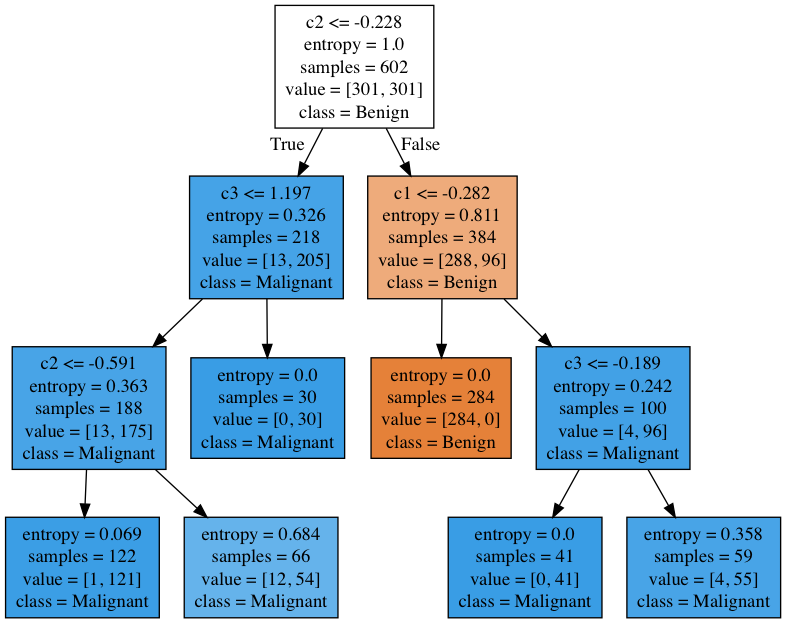

In [15]:
# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=3,
    random_state = 1337 # random_state is set to a high value so the tree can be reproduced
)
decision_tree.fit(x_train_pca_resampled, y_train_pca_resampled)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=pca_data.columns[:-1],
    class_names=['Benign', 'Malignant'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## The decision tree traces three rules to predict whether a cancer cell is malignant.
- If component 2 is <=-0.228, and c3 <= 1.197, the probability of the cell being malignant is 100%
- If component 2 is <=-0.591, and c3 <= 1.197, the probability of the cell being malignant is 93%
- If component 2 is <=-0.228, and c1 <=-0.282, but c3 <= -0.189, the probability of the cell being malignant is 100%

## Random Forest Classifier

Random Forest is a 'bagging' ensemble model consisting of multiple decision trees. The trees are generated with randomly selected samples of the data, having with varied depths (meaning the numbers of leaves and branches). Trees get a "vote" on the outcome of each observation. The predictions with most votes are returned.

In [16]:
# Call the model with the selected parameters
rfc = ensemble.RandomForestClassifier(bootstrap=True, min_samples_leaf=5, min_samples_split=2,
                                      n_estimators=100, max_features='sqrt', max_depth=10, n_jobs=-1)

# Call the cross-validation function
cv_models(rfc, 5, x_train_pca_resampled, y_train_pca_resampled, x_pca_test, y_pca_test)


Cross-Validation:

Sample range:  0 to 45
[[26  0]
 [ 1 18]]
Sensitivity:  1.0

Sample range:  45 to 90
[[30  0]
 [ 1 14]]
Sensitivity:  1.0

Sample range:  90 to 135
[[25  0]
 [ 0 20]]
Sensitivity:  1.0

Sample range:  135 to 180
[[31  0]
 [ 2 12]]
Sensitivity:  1.0

Sample range:  180 to 225
[[23  1]
 [ 1 20]]
Sensitivity:  0.9523809523809523

Average sensitivity =  0.9904761904761905

--- time elapsed 0.8650250434875488 seconds ---


The above Random Forest parameters resulted in high precision while measures were taken to prevent overfitting. Max tree depth was kept at 10 features (larger trees can pick up noise and random fluctuations of the testing data). Also, the number of estimators were set to 100, to increase randomness and prevent overfitting. Finally, bootstrap was set to True, meaning that sampling was made with replacement, increasing the chance of having representative samples and decresing chance of overfitting.

## Logistic Regression

Logistic regression can be used to calculate the probability (obtained as the log odds) of getting y=1 (a fraud transaction) rather than y=0 (non-fraud).

In [17]:
# Declare the model with the selected parameters
logit = LogisticRegression(penalty='l1', solver='saga', C=1, warm_start=False,
                           fit_intercept=True, n_jobs=-1)

# Call the custom cross-validation function
cv_models(logit, 5, x_train_pca_resampled, y_train_pca_resampled, x_pca_test, y_pca_test)


Cross-Validation:

Sample range:  0 to 45
[[26  1]
 [ 1 17]]
Sensitivity:  0.9444444444444444

Sample range:  45 to 90
[[30  0]
 [ 1 14]]
Sensitivity:  1.0

Sample range:  90 to 135
[[25  0]
 [ 0 20]]
Sensitivity:  1.0

Sample range:  135 to 180
[[31  0]
 [ 2 12]]
Sensitivity:  1.0

Sample range:  180 to 225
[[23  1]
 [ 1 20]]
Sensitivity:  0.9523809523809523

Average sensitivity =  0.9793650793650794

--- time elapsed 0.128662109375 seconds ---


The selected lasso 'l1' regularization parameter penalizes large coeficients by multiplying the sum of the absolute values of the coefficients by the value set in the 'C' parameter. Setting C=1 essentially makes the model a 'vanilla' logistic regression with no regularization.

With 'warm_start' the algorithm reuses the solution of the previous call to fit as initialization. When warm_start was set as True, the predictions were overfitted and all sensitivity scores equal to 1.

The 'saga' solver algorithm parameter ([stochastic average gradient descent](http://scikit-learn.org/stable/modules/sgd.html#sgd)) is an algorithm that has been successfully applied to large and sparse data sets. Saga scored 0.03 points higher than the default 'liblinear'.

### Support Vector Machine Classifier
The Support Vector Machine Classifier (SVC) is an effective machine learning method for high dimensional spaces, including when the number of variables (or dimensions) exceeds the number of samples.

In SVC, the data is plotted as points in an n-dimensional space (with 'n' being the number of variables + the cost function).  The term 'support vectors' refers to the vector coordinates of each data point. SVC finds the ideal boundary that differentiates the points into classes. The boundary consists of a hyperplane with an n-minus-one-dimension, that maximizes the sum of the distances between the boundary and the data points, while minimizing the cumulative distance of points on the wrong side of the margin.

It is a computationally expensive method that is considered highly effective for smaller data sets, but problematic on larger data sets. Finally, the SVC model calculates probability values using expensive five-fold cross-validation.

In [18]:
# Call the model with selected parameters
svc = svm.SVC(cache_size=1000, C=1, decision_function_shape='ovo', kernel='linear', gamma=1)

# Call the custom cross-validation function
cv_models(svc, 5, x_train_pca_resampled, y_train_pca_resampled, x_pca_test, y_pca_test)


Cross-Validation:

Sample range:  0 to 45
[[26  1]
 [ 1 17]]
Sensitivity:  0.9444444444444444

Sample range:  45 to 90
[[30  0]
 [ 1 14]]
Sensitivity:  1.0

Sample range:  90 to 135
[[25  0]
 [ 0 20]]
Sensitivity:  1.0

Sample range:  135 to 180
[[31  0]
 [ 2 12]]
Sensitivity:  1.0

Sample range:  180 to 225
[[23  0]
 [ 1 21]]
Sensitivity:  1.0

Average sensitivity =  0.9888888888888889

--- time elapsed 0.025476932525634766 seconds ---


The decision_function_shape was set to one-vs-one (OVO), where a separate classifier is trained for each pair of variables. This leads to N(N−1)/2 classifiers. OVO is recommended for imbalanced datasets but is more computationally expensive.

The kernel parameter is a function that computes how similar two vectors are. SVC's default 'rbf' [*radial basis function*](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) kernel computes the exponential function of the squared euclidean distance between two feature vectors multiplied by the negative gamma coefficient.

The RBF formula is K(x,x') = exp(-γ||x-x'||^2)

The C parameter is the penalty for error (e.g., for a point being outside its boundary). Increasing either (or both) the C and the gamma values will increase the fitting of the boundary to the data, increasing the chances of overfitting.

### Gradient Boosting
The gradient boosting classifier used here is an ensemble of "weak" decision trees that are run in sequence. The residuals of each decision tree is used as the outcome to be predicted by the subsequent tree. The cost function used is the sum of the negative log odds. Predictions are given by adding the values of all decision trees.

In [19]:
# Call the model with selected parameters
gbc = ensemble.GradientBoostingClassifier(max_depth=3, loss='exponential', n_estimators=100,
                                          criterion='friedman_mse')

# Call the custom cross-validation function
cv_models(gbc, 5, x_train_pca_resampled, y_train_pca_resampled, x_pca_test, y_pca_test)


Cross-Validation:

Sample range:  0 to 45
[[26  1]
 [ 1 17]]
Sensitivity:  0.9444444444444444

Sample range:  45 to 90
[[30  0]
 [ 1 14]]
Sensitivity:  1.0

Sample range:  90 to 135
[[25  1]
 [ 0 19]]
Sensitivity:  0.95

Sample range:  135 to 180
[[32  0]
 [ 1 12]]
Sensitivity:  1.0

Sample range:  180 to 225
[[23  0]
 [ 1 21]]
Sensitivity:  1.0

Average sensitivity =  0.9788888888888888

--- time elapsed 0.09853100776672363 seconds ---


To prevent overfitting, weak decision trees were used, with max depth of 3 and the number of estimators of 100. 

The “friedman_mse” criterion parameter is the function used to measure the quality of a split. It is the mean squared error modified specifically for gradient boosting.

The 'deviance' loss function is a probability estimate calculated by the negative log-odds ratio. The 'exponential' loss function is an estimator that gives greater weights to errors.

## Most indicative cancer traits

In addition to predicting breast cancer, we want to identify which traits are most indicative of whether or not an individual will be diagnosed. Scikit-learn's Recursive Feature Selection is used here to select the five most important features (or traits) in the data set. 

RFE takes an *estimator* to assign weights to features. Valid estimators are machine learning models that have a **fit** method and return a **coef\_** attribute (such as Logistic Regression) or a **feature\_importances_** attribute (such as Random Forests). We'll run RFE with Random Forest as the estimator.

In [20]:
# Declare the estimator model
model = ensemble.RandomForestClassifier()

# Call the RFE function and number of features to be selected
rfe = RFE(model, 1)

# Fit RFE with scaled data
fit = rfe.fit(scaled_data.iloc[:,1:-1], scaled_data.iloc[:,-1])

# Inspect the results
print("Feature Ranking:", fit.ranking_)

Feature Ranking: [3 2 7 5 1 6 4 8]


The top three features are (1st) cell_size, (2nd) nuclei, (3rd) cell_shape.

## Conclusion
All models performed well with PCA. Model results varied widely when applied to resampled data without PCA. This is because many of the raw data variables were highly correlated, leading to unstable models. Small changes between colinear variables can lead to wild swings in estimated coefficients, and/or increases in one may be offset by decreases in the other, negating their effects.

PCA transforms the data in such a way that the first component has the largest possible variance and any succeeding component is orthogonal to the preceding components. This leads to models that are more computationally efficient (one or two variables can explain the variance in the entire data set) and with lower risk of overfitting.